# Snake

In [1]:
import numpy as np
from  tqdm import trange
import matplotlib.pyplot as plt
import random
import tensorflow as tf

tf.random.set_seed(0)
random.seed(0)
np.random.seed(0)

2024-03-16 13:53:29.259074: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-16 13:53:29.294029: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-16 13:53:29.294064: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-16 13:53:29.294977: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-16 13:53:29.301376: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import sys
sys.path.append('/content/Snake/')
import environments_fully_observable
import environments_partially_observable
import os
import io
import imageio
from IPython.display import display, Image

## Environment definition

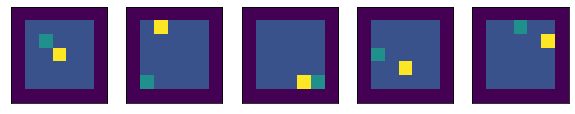

In [3]:
%matplotlib inline
# function to standardize getting an env for the whole notebook
def get_env(n=1000):
    # n is the number of boards that you want to simulate parallely
    # size is the size of each board, also considering the borders
    # mask for the partially observable, is the size of the local neighborhood
    size = 7
    e = environments_fully_observable.OriginalSnakeEnvironment(n, size)
    #e = environments_partially_observable.OriginalSnakeEnvironment(n, size, 2)
    return e
env_ = get_env(100)
GAMMA = .99
ITERATIONS = 5000

fig,axs=plt.subplots(1,min(len(env_.boards), 5), figsize=(10,3))
for ax, board in zip(axs, env_.boards):
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.imshow(board, origin="lower")


In [4]:
def fig_to_image(fig):
    # Convert the figure to a PNG image in memory
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    # Read the PNG image from memory and return it
    return imageio.v2.imread(buf)


## Model

In [5]:
class Agent:
    def __init__(self, env: environments_fully_observable.BaseEnvironment, discount=GAMMA, step_size=1e-3):
        self.discount = discount
        self.network = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, kernel_initializer = tf.keras.initializers.HeNormal()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation(tf.nn.relu),
            tf.keras.layers.Dense(128, kernel_initializer = tf.keras.initializers.HeNormal()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation(tf.nn.relu),
            tf.keras.layers.Dense(4, activation='linear', kernel_initializer = tf.keras.initializers.HeNormal())
        ])       
        self.target_network = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, kernel_initializer = tf.keras.initializers.HeNormal()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation(tf.nn.relu),
            tf.keras.layers.Dense(128, kernel_initializer = tf.keras.initializers.HeNormal()),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation(tf.nn.relu),
            tf.keras.layers.Dense(4, activation='linear', kernel_initializer = tf.keras.initializers.HeNormal())
        ])
        self.optimizer_net = tf.keras.optimizers.Adam(step_size)

## Training

In [6]:
# Define variables for training
train_env = get_env(100)
train_agent = Agent(train_env.boards)
train_total_rewards, train_fruits_eaten, train_wall_hits, train_body_hits = [], [], [], []
epsilon = 1.0
min_epsilon = 0.1
decay_rate = 0.99
mse = tf.keras.losses.MeanSquaredError() 

for iteration in trange(50000):
    if iteration % 150 == 0 and epsilon > min_epsilon: 
        epsilon = epsilon * decay_rate
    if iteration % 1000 == 0:
        print(f"{iteration}/{50000} - {np.mean(train_total_rewards[-30:]) or 0}", end="\n")
    
    # Get current state of the board 
    states = train_env.to_state()
    #states = tf.reshape(tf.math.argmax(states, axis=-1), (len(train_env.boards), train_env.board_size, train_env.board_size)) + tf.cast(tf.reduce_sum(states, axis=-1), tf.int64)
    
    with tf.GradientTape(persistent=True) as tape:

        # Compute the q-values for the current state
        q_values = train_agent.network(states)
        
        # Sample action using an epsilon-greedy policy based on Q
        if np.random.rand() < epsilon:
            train_actions = tf.random.categorical(q_values, 1)
        else: 
            train_actions = tf.expand_dims(tf.argmax(q_values, axis=1), axis=1)
        
        # Observe rewards
        train_rewards = train_env.move(train_actions)

        # Collect some data
        train_fruits_eaten.append(tf.math.count_nonzero(tf.reshape(train_rewards, -1) == 0.5).numpy())
        train_wall_hits.append(tf.math.count_nonzero(tf.reshape(train_rewards, -1) == -0.1).numpy())
        train_body_hits.append(tf.math.count_nonzero(tf.reshape(train_rewards, -1) == -0.2).numpy())
        train_total_rewards.append(np.mean(train_rewards))
        
        # Observe new states
        new_states = train_env.to_state()
        #new_states = tf.reshape(tf.math.argmax(new_states, axis=-1), (len(train_env.boards), train_env.board_size, train_env.board_size)) + tf.cast(tf.reduce_sum(new_states, axis=-1), tf.int64)
        
        # Start learning
        one_hot_actions = tf.reshape(tf.one_hot(train_actions, 4), (len(train_env.boards), 4))
        action_net = train_agent.network(states)
        actions_q_value = tf.reduce_sum(one_hot_actions * action_net, axis=-1, keepdims=True)
        q_target = train_agent.target_network(new_states)

        # Compute loss of iteration
        y_i = train_rewards  + train_agent.discount * tf.expand_dims(tf.reduce_max(q_target, axis=1), axis=1)
        loss = mse(y_i, actions_q_value)
        
    # Update weights of the network
    gradient = tape.gradient(loss, train_agent.network.trainable_weights)
    train_agent.optimizer_net.apply_gradients(zip(gradient, train_agent.network.trainable_weights))           

    # Every 2000 iterations update the weights of the target network
    if iteration % 2000 == 0:
        train_agent.target_network.set_weights(train_agent.network.get_weights())         

2024-03-16 13:53:31.785200: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-16 13:53:31.832251: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-16 13:53:31.832312: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-16 13:53:31.835802: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-16 13:53:31.835866: I external/local_xla/xla/stream_executor

0/50000 - nan


2024-03-16 13:53:33.410269: I external/local_xla/xla/service/service.cc:168] XLA service 0x55bcb25feb20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-16 13:53:33.410329: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce MX450, Compute Capability 7.5
2024-03-16 13:53:33.417719: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-16 13:53:33.448100: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1710593613.626042  153207 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  2%|██▏                                                                                                         | 1003/50000 [00:57<46:36, 17.52it/s]

1000/50000 - -0.011866665445268154


  4%|████▎                                                                                                       | 2003/50000 [01:53<45:25, 17.61it/s]

2000/50000 - -0.010466666892170906


  6%|██████▍                                                                                                     | 3002/50000 [02:47<41:16, 18.98it/s]

3000/50000 - -0.004866666626185179


  8%|████████▋                                                                                                   | 4001/50000 [03:39<38:26, 19.94it/s]

4000/50000 - -6.666649278486148e-05


 10%|██████████▊                                                                                                 | 5003/50000 [04:32<43:33, 17.22it/s]

5000/50000 - 0.00956666562706232


 12%|████████████▉                                                                                               | 6002/50000 [05:27<41:38, 17.61it/s]

6000/50000 - 0.009499999694526196


 14%|███████████████                                                                                             | 7001/50000 [06:22<33:35, 21.34it/s]

7000/50000 - 0.020233333110809326


 16%|█████████████████▎                                                                                          | 8002/50000 [07:19<45:03, 15.54it/s]

8000/50000 - 0.03073333017528057


 18%|███████████████████▍                                                                                        | 9003/50000 [08:15<42:54, 15.93it/s]

9000/50000 - 0.03399999812245369


 20%|█████████████████████▍                                                                                     | 10002/50000 [09:13<43:16, 15.41it/s]

10000/50000 - 0.044700004160404205


 22%|███████████████████████▌                                                                                   | 11003/50000 [10:12<36:23, 17.86it/s]

11000/50000 - 0.04803333058953285


 24%|█████████████████████████▋                                                                                 | 12002/50000 [11:10<37:31, 16.88it/s]

12000/50000 - 0.03293333202600479


 26%|███████████████████████████▊                                                                               | 13002/50000 [12:07<38:22, 16.07it/s]

13000/50000 - 0.05263333395123482


 28%|█████████████████████████████▉                                                                             | 14002/50000 [13:04<37:05, 16.17it/s]

14000/50000 - 0.08416666835546494


 30%|████████████████████████████████                                                                           | 15004/50000 [14:02<33:18, 17.51it/s]

15000/50000 - 0.09220001101493835


 32%|██████████████████████████████████▏                                                                        | 16002/50000 [14:59<35:50, 15.81it/s]

16000/50000 - 0.07463333010673523


 34%|████████████████████████████████████▍                                                                      | 17002/50000 [16:02<30:58, 17.76it/s]

17000/50000 - 0.08579999953508377


 36%|██████████████████████████████████████▌                                                                    | 18003/50000 [17:03<35:13, 15.14it/s]

18000/50000 - 0.09310000389814377


 38%|████████████████████████████████████████▋                                                                  | 19002/50000 [18:04<29:53, 17.29it/s]

19000/50000 - 0.08896667510271072


 40%|██████████████████████████████████████████▊                                                                | 20002/50000 [19:02<28:56, 17.28it/s]

20000/50000 - 0.07570000737905502


 42%|████████████████████████████████████████████▉                                                              | 21003/50000 [20:04<30:48, 15.69it/s]

21000/50000 - 0.07136666774749756


 44%|███████████████████████████████████████████████                                                            | 22001/50000 [21:03<30:19, 15.39it/s]

22000/50000 - 0.05816667526960373


 46%|█████████████████████████████████████████████████▏                                                         | 23001/50000 [22:21<32:04, 14.03it/s]

23000/50000 - 0.08856666833162308


 48%|███████████████████████████████████████████████████▎                                                       | 24001/50000 [23:35<30:14, 14.33it/s]

24000/50000 - 0.09616667777299881


 50%|█████████████████████████████████████████████████████▌                                                     | 25003/50000 [24:43<25:41, 16.22it/s]

25000/50000 - 0.09019999951124191


 52%|███████████████████████████████████████████████████████▋                                                   | 26001/50000 [25:46<25:35, 15.63it/s]

26000/50000 - 0.10763333737850189


 54%|█████████████████████████████████████████████████████████▊                                                 | 27000/50000 [26:46<30:20, 12.63it/s]

27000/50000 - 0.113433338701725


 56%|███████████████████████████████████████████████████████████▉                                               | 28001/50000 [27:49<22:32, 16.26it/s]

28000/50000 - 0.11889999359846115


 58%|██████████████████████████████████████████████████████████████                                             | 29002/50000 [28:47<19:49, 17.66it/s]

29000/50000 - 0.10379999130964279


 60%|████████████████████████████████████████████████████████████████▏                                          | 30003/50000 [29:30<13:50, 24.07it/s]

30000/50000 - 0.10703333467245102


 62%|██████████████████████████████████████████████████████████████████▎                                        | 31005/50000 [30:10<11:42, 27.04it/s]

31000/50000 - 0.10790000110864639


 64%|████████████████████████████████████████████████████████████████████▍                                      | 32002/50000 [30:54<14:50, 20.22it/s]

32000/50000 - 0.13196666538715363


 66%|██████████████████████████████████████████████████████████████████████▌                                    | 33002/50000 [31:34<11:07, 25.48it/s]

33000/50000 - 0.11966666579246521


 68%|████████████████████████████████████████████████████████████████████████▊                                  | 34001/50000 [32:17<12:27, 21.40it/s]

34000/50000 - 0.11950000375509262


 70%|██████████████████████████████████████████████████████████████████████████▉                                | 35005/50000 [32:58<09:37, 25.97it/s]

35000/50000 - 0.1017666608095169


 72%|█████████████████████████████████████████████████████████████████████████████                              | 36004/50000 [33:36<08:53, 26.24it/s]

36000/50000 - 0.1296333372592926


 74%|███████████████████████████████████████████████████████████████████████████████▏                           | 37003/50000 [34:14<08:06, 26.71it/s]

37000/50000 - 0.11616666615009308


 76%|█████████████████████████████████████████████████████████████████████████████████▎                         | 38005/50000 [34:53<07:38, 26.15it/s]

38000/50000 - 0.11160000413656235


 78%|███████████████████████████████████████████████████████████████████████████████████▍                       | 39004/50000 [35:30<06:45, 27.12it/s]

39000/50000 - 0.11286664754152298


 80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 40003/50000 [36:08<06:49, 24.41it/s]

40000/50000 - 0.11719999462366104


 82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 41003/50000 [36:51<07:01, 21.33it/s]

41000/50000 - 0.12296666949987411


 84%|█████████████████████████████████████████████████████████████████████████████████████████▉                 | 42002/50000 [37:32<05:33, 23.97it/s]

42000/50000 - 0.10480000078678131


 86%|████████████████████████████████████████████████████████████████████████████████████████████               | 43004/50000 [38:14<04:34, 25.49it/s]

43000/50000 - 0.1333666443824768


 88%|██████████████████████████████████████████████████████████████████████████████████████████████▏            | 44003/50000 [38:55<04:13, 23.67it/s]

44000/50000 - 0.10856667160987854


 90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 45003/50000 [39:39<03:22, 24.68it/s]

45000/50000 - 0.10829999297857285


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▍        | 46004/50000 [40:23<02:43, 24.51it/s]

46000/50000 - 0.10533333569765091


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 47001/50000 [41:11<03:07, 16.00it/s]

47000/50000 - 0.11836665123701096


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 48001/50000 [42:14<02:28, 13.45it/s]

48000/50000 - 0.12916666269302368


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 49003/50000 [43:21<01:01, 16.19it/s]

49000/50000 - 0.10240001231431961


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [44:34<00:00, 18.70it/s]


In [7]:
train_agent.network.save_weights('weights')

In [20]:
np.save('train_fruits.npy', train_fruits_eaten)
np.save('train_walls.npy', train_wall_hits)
np.save('train_bodies.npy', train_body_hits)
np.save('train_reward.npy', train_total_rewards)

# Heuristic/Baseline Policy #

In [8]:
def retrieveBoardPositions(board):
    """
        Function to retrieve the position of the elements in the board.
    """
    head = np.argwhere(board == environments_fully_observable.BaseEnvironment.HEAD)
    walls = np.argwhere(board == environments_fully_observable.BaseEnvironment.WALL)
    fruit = np.argwhere(board == environments_fully_observable.BaseEnvironment.FRUIT)
    body = np.argwhere(board == environments_fully_observable.BaseEnvironment.BODY)
    return head, walls, fruit, body

In [9]:
def computePath(board, boards_size, prev_head):
    paths = []
    head, walls, fruit, body = retrieveBoardPositions(board)
    paths = BFS(head, walls, fruit, body)
    if len(paths) > 0:
        return paths
    else:
        paths = nextMove(head, body, walls, prev_head)
        return paths

In [10]:
def getDirections(step, heads):
    directions = {(1, 0): 'UP', (0, -1): 'LEFT', (-1, 0): 'DOWN', (0, 1): 'RIGHT'}
    step = np.array(step)
    heads = np.array(heads)
    diff = step - heads # Calculate the coordinate differences

    # Initialize an empty list to store the directions
    directions_list = []

    # Check the differences in coordinates to determine the direction of movement
    for d in diff:
        if d[0] == 1:
            directions_list.append('UP')
        elif d[0] == -1:
            directions_list.append('DOWN')
        elif d[1] == -1:
            directions_list.append('LEFT')
        elif d[1] == 1:
            directions_list.append('RIGHT')
        else:
            directions_list.append('UNKNOWN')

    return directions_list

In [11]:
def getProbabilities(directions):
    prob = []
    for direction in directions:
        if direction == 'UP':
            prob.append([1,0,0,0])
        elif direction == 'RIGHT':
            prob.append([0,1,0,0])
        elif direction == 'DOWN':
            prob.append([0,0,1,0])
        elif direction == 'LEFT':
            prob.append([0,0,0,1])
        else:
            prob.append([4,4,0,0,0])
    return prob

In [12]:
def nextMove(head, body, walls, prev_head):
    movements = np.array([[1, 0], [0, 1], [-1, 0], [0, -1]])
    new_heads = head + movements
    prev_head = np.array(prev_head[1:])
    indices = []
    # Iterate through each row in heads
    for head in new_heads:
        # Check if the row is present in body
        if not np.array_equal(head, prev_head):
            if not any(np.array_equal(head, w) for w in walls) and not any(np.array_equal(head, b) for b in body):
                return [head]
            else:
                matching_rows = np.where(np.all(body == head, axis=1))[0]
                if matching_rows.size > 0:
                    indices.append(matching_rows[0])
    if len(indices) > 0:
        move = np.random.choice(indices)
        path = [body[move]]
        return path

In [13]:
def BFS(head, walls, fruit, body):
    visited = []
    queue = [(head[0], [])]  # Initialize queue with start cell and empty path
    movements = np.array([[1, 0], [0, 1], [-1, 0], [0, -1]])
    while queue:
        current, path = queue.pop(0)
        if np.array_equal(current, fruit[0]):
            path.append(current)
            return path[1:]

        if any(np.all(current == v) for v in visited):
            continue

        visited.append(current)
        # Check each adjacent cell
        new_heads = current + movements

        for neighbor in new_heads:
            if not any(np.array_equal(neighbor, v) for v in visited):
                if not any(np.array_equal(neighbor, w) for w in walls) and not any(np.array_equal(neighbor, b) for b in body):
                    queue.append((neighbor, path + [current]))
    return []

In [74]:
# Define variables for heuristic approach 
heur_env = get_env(100) # Environment, we just pick one board to go faster
heur_reward, heur_fruits, heur_wall_hits, heur_body_hits = [], [], [], []
paths = [[] for _ in range(len(heur_env.boards))]
prev_head = [[]for _ in range(len(heur_env.boards))]

"""
output_folder = 'plot_images_folder'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
plot_images = []
"""

for t in trange(50000):
    # For each path to the fruit check if it is empty or not
    # This is to handle the case of multiple boards playing in parallel. Different boards may have different lenght of 
    # thus we need to handle each path separately 
    for p in range(len(paths)):
        if not paths[p]:
            # If the path is empty we compute a new one to the fruit for the specific board
            paths[p] = computePath(heur_env.boards[p], heur_env.board_size, prev_head[p])
    if t % 1000 == 0:
        print(f"{t}/{50000} - {np.mean(heur_reward[-30:]) or 0}", end="\n")
    
    # Get the first step from each path in the array of paths
    step = [path.pop(0) for path in paths if path]
    
    # Get the direction of the step, need step and current cell location
    directions = getDirections(step, np.argwhere(heur_env.boards == environments_fully_observable.BaseEnvironment.HEAD)[:,[1,2]])
    
    # Compute the probability of taking that step
    probabs = getProbabilities(directions)
    probabilities = tf.convert_to_tensor(probabs)
    
    # Compute the action array
    heur_actions =  tf.expand_dims(tf.argmax(probabilities, axis=1, output_type=tf.int32), axis=1)

    """
    figs, axs=plt.subplots(1, 1, figsize=(10,3))
    axs.get_yaxis().set_visible(False)
    axs.get_xaxis().set_visible(False)
    axs.imshow(heur_env.boards[0], origin="lower")
    """
    
    # Save position of the current head. This is needed such that if, when there is the necessity of computing a new path
    # the snake does not find one to the fruit, it avoids to eat "behind hime" in such a way that we do not lose all the body
    prev_head = np.argwhere(heur_env.boards == environments_fully_observable.BaseEnvironment.HEAD)

    # Observe reward by performing the actions selected
    rew = heur_env.move(heur_actions)

    # Collect data (mean_reward and number of fruit eaten)
    heur_reward.append(np.mean(rew))
    heur_fruits.append(tf.math.count_nonzero(tf.reshape(rew, -1) == 0.5).numpy())
    heur_wall_hits.append(tf.math.count_nonzero(tf.reshape(rew, -1) == -0.1).numpy())
    heur_body_hits.append(tf.math.count_nonzero(tf.reshape(rew, -1) == -0.2).numpy())
    """
    # Append the current plot to the list
    plot_images.append(fig_to_image(figs))
    plot_image_path = os.path.join(output_folder, f'plot_{t:04d}.png')
    plt.savefig(plot_image_path, bbox_inches='tight', pad_inches=0)
    plt.close()  # Close the figure to prevent displaying inline
    """
    
# Create the animated GIF from the plots
#output_gif = 'snake_game_BFS.gif'
#imageio.mimsave(output_gif, plot_images_folder, duration=0.5)
#display(Image(filename=output_gif))

  0%|                                                                                                                       | 0/50000 [00:00<?, ?it/s]/home/michele/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/michele/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  0%|                                                                                                             | 3/50000 [00:00<1:36:38,  8.62it/s]

0/50000 - nan


  1%|▋                                                                                                            | 319/50000 [00:22<59:40, 13.87it/s]


KeyboardInterrupt: 

# Agent evaluation #

In [24]:
np.save('heur_fruits.npy', heur_fruits)
np.save('heur_walls.npy', heur_wall_hits)
np.save('heur__bodies.npy', heur_body_hits)
np.save('heur_reward.npy', heur_reward)

In [15]:
evaluation_env = get_env(100)
evaluation_agent = Agent(evaluation_env)
evaluation_agent.network.load_weights('weights')

In [16]:
eval_fruits_eaten, eval_rewards = [], []

for t in trange(50000):
    # Interact with environment
    state = evaluation_env.to_state()
    q_values = evaluation_agent.network(state)
    actions = tf.expand_dims(tf.argmax(q_values, axis=1), axis=1)
    rewards = evaluation_env.move(actions)

    # Collect some data
    eval_fruits_eaten.append(tf.math.count_nonzero(tf.reshape(rewards, -1) == 0.5).numpy())
    eval_rewards.append(np.mean(rewards))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [18:50<00:00, 44.22it/s]


In [30]:
efr = eval_fruits_eaten
tfr = train_fruits_eaten

#hfr = heur_fruits
print("ALL BELOW DATA ARE GATHERED OVER 50000 ITERATIONS")
print("Average reward achieved by the agent over one board:", np.mean(eval_rewards))
print("Average reward achieved by the heuristic policy over one board:", np.mean(heur_reward))
print("Fruits eaten by the agent on average in one board:", np.sum(efr)/100)
print("Fruits eaten by the heuristic policy one average in one board:", np.sum(heur_fruits))
print("Average number of times the agent hits the wall in one board:", np.sum(train_wall_hits)/100)
print("Average number of times the heuristic policy hits the wall in one board:", np.sum(heur_wall_hits))
print("Average number of times the agent hits the body in one board:", np.sum(train_body_hits)/100)
print("Average number of times the heuristic policy hits the body in one board:", np.sum(heur_body_hits))

ALL BELOW DATA ARE GATHERED OVER 50000 ITERATIONS
Average reward achieved by the agent over one board: 0.13298593
Average reward achieved by the heuristic policy over one board: 0.10934201
Fruits eaten by the agent on average in one board: 14411.83
Fruits eaten by the heuristic policy one average in one board: 11535
Average number of times the agent hits the wall in one board: 2387.77
Average number of times the heuristic policy hits the wall in one board: 0
Average number of times the agent hits the body in one board: 3551.04
Average number of times the heuristic policy hits the body in one board: 1562


# Plots #

In [133]:
heur_fruits = np.load('heur_fruits.npy')
heur_wall_hits = np.load('heur_walls.npy')
heur_body_hits = np.load('heur__bodies.npy')
heur_reward = np.load('heur_reward.npy')

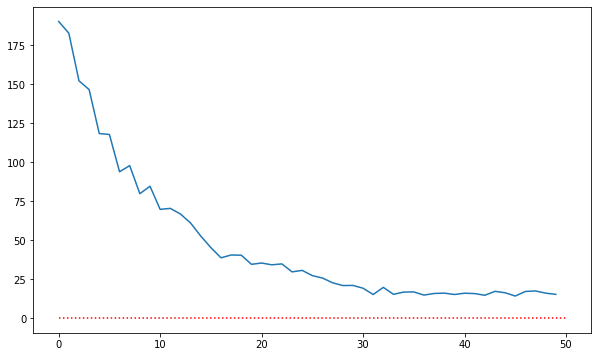

In [134]:
fig. axs = plt.figure(figsize=(10, 6))

"""
Train total rewards:
    - collected at each iteration
    - avg reward among all 100 boards

Need to reshape array such that it can be plotted

Train fruit eaten:
    - for the heuristic policy we have that over a 1000 iterations, the policy is capable to eat 230 fruits
    - for the agent we can see how the training process allows to reach 250 fruits over 1000 iterations

Body hits:
    -
"""

train_wh = train_wall_hits
train_wh = np.sum(np.reshape(train_wh, (50, 1000)), axis = 1)/100
plt.plot(train_wh)
plt.hlines(np.mean(np.sum(np.reshape(heur_wall_hits, (50, 1000)), axis=1)), 0, 50, colors='red', label='heuristic', linestyles='dotted')
plt.show()


## Training ##

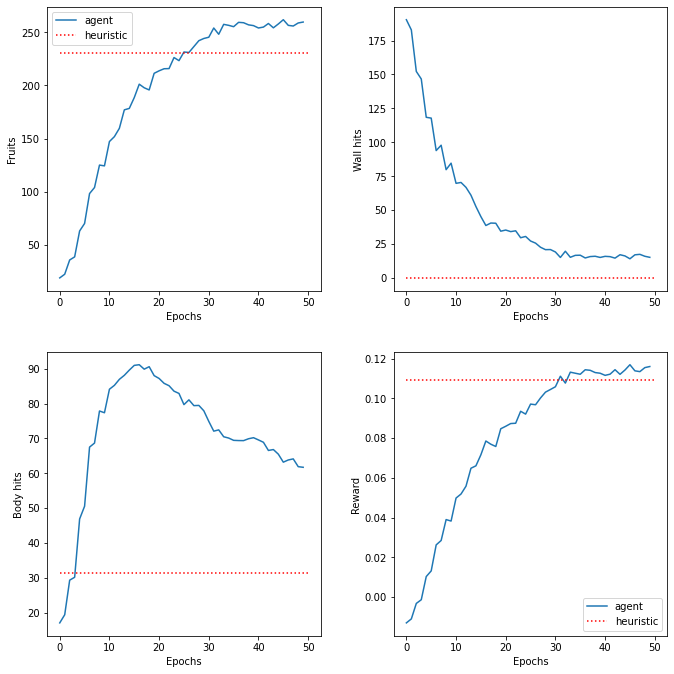

In [135]:
# Training statistics
train_fruits = train_fruits_eaten
train_reward = train_total_rewards
train_wh = train_wall_hits
train_bh = train_body_hits

# Heuristic statistics
heur_fe = heur_fruits
heur_wh = heur_wall_hits
heur_bh = heur_body_hits
heuristic_reward = heur_reward

N = 1000

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

train_fruits = np.sum(np.reshape(train_fruits, (50, 1000)), axis = 1)/100
axs[0, 0].plot(train_fruits, label='agent')
axs[0, 0].hlines(np.mean(np.sum(np.reshape(heur_fruits, (50, 1000)), axis=1)), 0, 50, label='heuristic', color='red', linestyle='dotted')
axs[0, 0].set(ylabel='Fruits')
axs[0, 0].set(xlabel="Epochs")
axs[0, 0].legend()

train_wh = train_wall_hits
train_wh = np.sum(np.reshape(train_wh, (50, 1000)), axis = 1)/100
axs[0, 1].plot(train_wh)
axs[0, 1].hlines(np.mean(np.sum(np.reshape(heur_wall_hits, (50, 1000)), axis=1)), 0, 50, colors='red', label='heuristic', linestyles='dotted')
axs[0, 1].set(ylabel='Wall hits')
axs[0, 1].set(xlabel="Epochs")

train_bh = np.sum(np.reshape(train_bh, (50, 1000)), axis = 1)/100
axs[1, 0].plot(train_bh)
axs[1, 0].hlines(np.mean(np.sum(np.reshape(heur_body_hits, (50, 1000)), axis=1)), 0, 50, colors='red', label='heuristic', linestyles='dotted')
axs[1, 0].set(ylabel='Body hits')
axs[1, 0].set(xlabel="Epochs")

train_reward = np.mean(np.reshape(train_reward, (50, 1000)), axis=1)
axs[1, 1].plot(train_reward, label='agent')
axs[1, 1].hlines(np.mean(heuristic_reward), 0, 50, colors='red', label='heuristic', linestyles='dotted')
axs[1, 1].set(ylabel='Reward')
axs[1, 1].set(xlabel="Epochs")
axs[1, 1].legend(loc='lower right')

fig.tight_layout(pad=3.0)

## Evaluation ##

/tmp/ipykernel_153207/1341888637.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels('A')
/tmp/ipykernel_153207/1341888637.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels('H')
/tmp/ipykernel_153207/1341888637.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels('A')
/tmp/ipykernel_153207/1341888637.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_xticklabels('H')


[Text(657.704347826087, 0.5, 'Reward')]

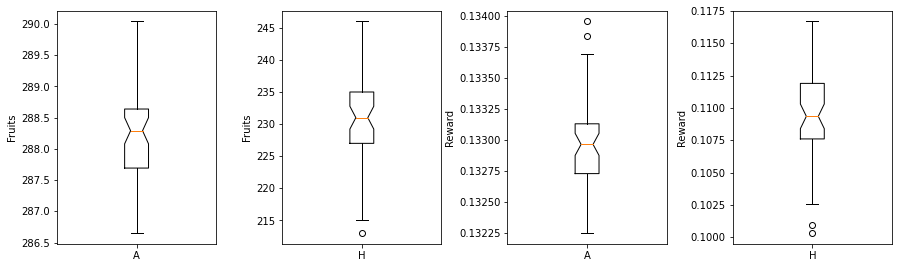

In [28]:
N = 1000 # number of iteration in each epoch

eval_f = eval_fruits_eaten
eval_r = eval_rewards
heur_f = heur_fruits
heur_r = heur_reward

fig, axs = plt.subplots(1, 4, figsize=(13, 4.5))
fig.tight_layout(pad=3.5)
axs[0].set_xticklabels('A')
axs[1].set_xticklabels('H')
axs[2].set_xticklabels('A')
axs[3].set_xticklabels('H')

# Plot number of fruits eaten by agent vs heuristic
eval_f = np.sum(np.reshape(eval_f, (50, 1000)), axis=1)/100
heur_f = np.sum(np.reshape(heur_f, (50, 1000)), axis=1)
axs[0].boxplot(eval_f, notch=True)
axs[1].boxplot(heur_f, notch=True)
axs[0].set(ylabel='Fruits')
axs[1].set(ylabel='Fruits')

# Plot reward of agent vs reward of heuristic
heur_r = np.reshape(heur_r[:len(heur_r) // N * N], (-1, N)).mean(axis=-1)
eval_r = np.reshape(eval_r[:len(eval_r) // N * N], (-1, N)).mean(axis=-1)
axs[2].boxplot(eval_r, notch=True)
axs[3].boxplot(heur_r, notch=True)
axs[2].set(ylabel='Reward')
axs[3].set(ylabel='Reward')